## Описание задачи

Вы работаете в стартапе, который продаёт продукты питания.   
Нужно разобраться, как ведут себя пользователи мобильного приложения.
Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?   
После этого исследовать результаты A/A/B-эксперимента.   
Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста.   
Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, какой шрифт лучше.

## Предобработка данных

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt 
from scipy import stats as st
import numpy as np
import math as mth


In [2]:
logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
# переименуем колонки
logs = logs.rename(columns={'EventName': 'event_name', 
                        'DeviceIDHash': 'user_id',
                        'EventTimestamp': 'event_timestamp',
                        'ExpId':'exp_id'  }
              )

In [4]:
# посмотрим на основные характеристики
display(logs.head()) 
logs.info() 
print ('\nКоличество явных дубликатов -', logs.duplicated().sum())

,event_name,user_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   user_id          244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB

Количество явных дубликатов - 413


In [5]:
logs['event_name'].value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event_name, dtype: int64

In [6]:
logs['event_name'].isna().sum(), logs['user_id'].isna().sum(),logs['event_timestamp'].isna().sum(),logs['exp_id'].isna().sum()

(0, 0, 0, 0)

In [7]:
# преобразуем секунды в тип дата
logs['event_time'] = pd.to_datetime(logs['event_timestamp'],unit = 's')

logs['event_time'] = pd.to_datetime(logs['event_time'], format='%d-%m-%Y')
logs['event_date'] = logs['event_time'].dt.date

logs.head()

,event_name,user_id,event_timestamp,exp_id,event_time,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [8]:
# посмотрим, сколько дубликатов
logs[logs.duplicated()].shape[0]

413

Дубликаты составляют менее 1% данных -> этими данными можно принебречь.Удалим эти стороки.


In [9]:
print('Строк в таблице изначально - ',logs.shape[0])
logs = logs.drop_duplicates()
print('Строк в таблице после удаления дубликатов - ',logs.shape[0])

Строк в таблице изначально -  244126
Строк в таблице после удаления дубликатов -  243713


У нас есть 5 событий:

MainScreenAppear(переход на главную страницу)          119205   
OffersScreenAppear (переход по ссылке на товар)        46825   
CartScreenAppear (добавление товара в корзину)         42731   
PaymentScreenSuccessful (оплата товара)                34313   
Tutorial (руководство по работе с сайтом)              1052

## Анализ данных

Каждая запись в логе — это действие пользователя, или событие.   

**event_name** — название события;   
**user_id** — уникальный идентификатор пользователя;   
**event_timestamp** — время события (в секундах);   
**event_time** -  время события ( дата + время);   
**event_date** - дата события;   
**exp_id** — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### Изучение и проверка данных

In [10]:
# сколько всего событий с логах
print('Всего событий - {}'.format(logs.shape[0]))

#cколько всего пользователей в логе?
print('Всего пользователей - {}'.format(logs['user_id'].nunique()))

#сколько в среднем событий приходится на пользователя?
print('В среднем на одного пользователя приходится -', round(logs.shape[0] /logs['user_id'].nunique()),'события')

Всего событий - 243713
Всего пользователей - 7551
В среднем на одного пользователя приходится - 32 события


In [11]:
logs_pivot = logs.pivot_table(index = 'user_id',values = 'event_name', aggfunc = 'count')
display(logs_pivot.head())
logs_pivot.describe()

,event_name
user_id,
6888746892508752,1
6909561520679493,5
6922444491712477,47
7435777799948366,6
7702139951469979,137


,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


Из данных тоже видно, что среднее число событий на пользователя = 32, но при этом 75% пользователей совершают 37 событий

In [12]:
logs.groupby('user_id').agg({'event_name':'count'}).sort_values(by = 'event_name')

,event_name
user_id,
6888746892508752,1
4033444713489412517,1
7962370797737085275,1
636273053050387468,1
1918918598819548986,1
...,...
1754140665440434215,1221
6932517045703054087,1439
4623191541214045580,1768


Посмотри, данными за какой период мы располагаем

In [13]:
print('Данные за период с', logs['event_date'].min(), 'по', logs['event_date'].max())

Данные за период с 2019-07-25 по 2019-08-07


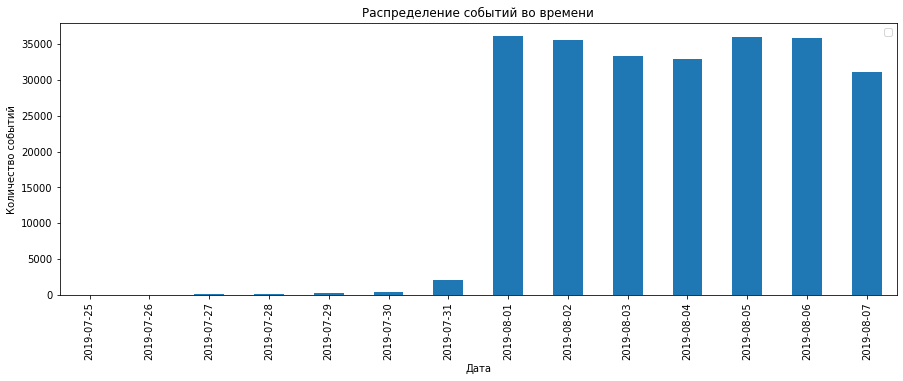

In [14]:
# построим гистограмму и посмотрим, как со временем изменялись наши события
logs.groupby('event_date').agg({'event_name':'count'}).plot(kind = 'bar',figsize = (15,5))
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.legend('')
plt.title('Распределение событий во времени');

Мы видим, что у нас до 01.08.2019 событий практически не было.Поэтому правильнее будет рассматривать данные начиная с 01.08.2019 по 07.08.2019.

In [15]:
# Запишем в переменные значения событий и пользователей по полным данным
event = logs.shape[0]
users = logs['user_id'].nunique()

logs = logs.query('event_date >= datetime(2019,8,1).date()')


print('Количество событий по полным данным -',event)
print('Количество событий после удаления -',logs.shape[0])
print('Удалено -',event-logs.shape[0], 'событий, что составляет',round(((1-(logs.shape[0]/event)) *100),2), '%')

print('\nКоличество пользователей по полным данным -',users)
print('Количество пользователей после удаления -',logs['user_id'].nunique())
print('Удалено -',users-logs['user_id'].nunique(), 'пользователей, что составляет',round(((1-(logs['user_id'].nunique()/users)) *100),2), '%')

logs.head()

Количество событий по полным данным - 243713
Количество событий после удаления - 240887
Удалено - 2826 событий, что составляет 1.16 %

Количество пользователей по полным данным - 7551
Количество пользователей после удаления - 7534
Удалено - 17 пользователей, что составляет 0.23 %


,event_name,user_id,event_timestamp,exp_id,event_time,event_date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [16]:
# посмотрим, чтоб в каждой группе были пользователи
logs.groupby('exp_id').agg({'user_id':'nunique'})

,user_id
exp_id,
246,2484
247,2513
248,2537


**Выводы**   
В каждой группе есть пользователи и на первый взгляд они распределены равномерно. Нет большого перекоса по численности в группах.   
В среднем на одного пользователя приходится - 32 события.   
Полноценно тест начался с 01.08.2019 по 07.08.2019. После удаления данных до 01.08.2019 было удалено 2826 событий, что составляет 1.16 % и удалено 17 пользователей, что составляет 0.23 %. Это не сильно большой процент от общего числа, поэтому можно считать, что результаты эксперимента не исказятся.

### Воронка событий

In [17]:
# посмотрим, какие события есть в логах
logs['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

MainScreenAppear(переход на главную страницу)             
OffersScreenAppear (переход по ссылке на товар)          
CartScreenAppear (добавление товара в корзину)           
PaymentScreenSuccessful (оплата товара)                  
Tutorial (руководство по работе с сайтом)              

Посмотрим, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [18]:

logs_event = logs.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by = 'user_id',ascending = False).reset_index()
print('Количество уникальных пользователей -', logs['user_id'].nunique())
logs_event['%'] = (logs_event['user_id']/logs['user_id'].nunique() *100)

logs_event.style.format({'%':'{:.2f}'})


Количество уникальных пользователей - 7534


,event_name,user_id,%
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

In [19]:
# Удалим из событий Tutorial, т.к. это событие не является бизнесс-процессом
logs_event = logs_event.query('event_name != "Tutorial"')

/tmp/ipykernel_347/3343932148.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs_event['conv'] = logs_event['user_id']/logs_event['user_id'].values[0]
/tmp/ipykernel_347/3343932148.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs_event['prev_step'] = logs_event['user_id'].shift()
/tmp/ipykernel_347/3343932148.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,event_name,user_id,%,conv,prev_step,sten_conv
0,MainScreenAppear,7419,98.473586,1.000000,NaN,NaN
1,OffersScreenAppear,4593,60.963632,0.619086,7419.0,0.619086
2,CartScreenAppear,3734,49.561986,0.503302,4593.0,0.812976
3,PaymentScreenSuccessful,3539,46.973719,0.477018,3734.0,0.947777


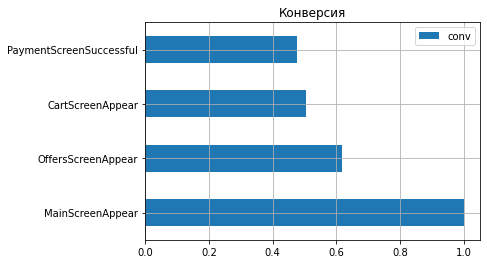

In [20]:

logs_event['conv'] = logs_event['user_id']/logs_event['user_id'].values[0]
logs_event['prev_step'] = logs_event['user_id'].shift()
logs_event['sten_conv'] = logs_event['user_id']/logs_event['prev_step']

display(logs_event)

# построим гистограмму конверсии
logs_event[['event_name','conv']].set_index('event_name').plot(kind = 'barh',stacked = True, grid = True)
plt.title('Конверсия')
plt.xlabel('')
plt.ylabel('');


Самые большие потери при переходе на второй шаг (40% потерь) - когда пользователь переходит по ссылке на товар. До оплаты товара доходит лишь 48% пользователей.   
Полагаю, что 40% потери пользоватлей на первом шаге - это большой процент. Возможно это связано с тем, что пользователь тратит много времени, чтоб найти необходимый товар. Необходимо посмотреть, как можно изменить интерфейс или функционал поиска товара, чтоб пользоватлею было удобнее осуществлять поиск нужного товара. Возможно необходимо расширить критерии поиска и у каждого товара сделать дополнительные критерии для более удобного и быстрого поиска. На остальных этапах покупки товара процент тех, кто не дошел до покупки приемлемый. 


## Результаты эксперимента

In [21]:
logs.head()

,event_name,user_id,event_timestamp,exp_id,event_time,event_date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


Есть 2 контрольные группы для А/А-эксперимента (246 и 247), чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

In [22]:
logs_246 = logs.query('exp_id == 246')
logs_247 = logs.query('exp_id == 247')
logs_248 = logs.query('exp_id == 248')

gr_246 = logs_246['user_id'].nunique()
gr_247 = logs_247['user_id'].nunique()
gr_248 = logs_248['user_id'].nunique()

print('Количество пользоватлей в группах 246 и 247 различается на', round(100 - (gr_246/gr_247*100),2),'%' )


Количество пользоватлей в группах 246 и 247 различается на 1.15 %


In [23]:
# посмотрим,есть ли пересечение в группах по пользователям
len(np.intersect1d(gr_246,gr_247)),len(np.intersect1d(gr_246,gr_248))

(0, 0)

In [24]:
# сколько пользователей в каждой эксперементальной группе
trials = logs.groupby('exp_id').agg({'user_id':'nunique'})
trials


,user_id
exp_id,
246,2484
247,2513
248,2537


In [25]:
# построим воронку по каждому событию с разбивкой по группам
funnel = logs.pivot_table(index = 'event_name',columns = 'exp_id',values = 'user_id',aggfunc = 'nunique').sort_values(by = 246,ascending = False)
funnel

exp_id,246,247,248
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


Проведем А/А тестирование и высним, если ли статистическая разница между группами 246 и 247.
    
Гипотезы:   
Н0 - между группами 246 и 247 нет отличий в доле пользователей совершивших событие   
Н1 - между группами 246 и 247 есть отличия в доле пользователей совершивших событие   
Гипотеза друхсторонняя   
   
Воспользуемся Z-тестом   
Z-тест - это статистический метод позволяющий определить, являются ли два средних значения выборки примерно одинаковыми или разными, если известна их дисперсия и размер выборки большой

In [26]:
# функция для проверки статистической значимости выборки
#
def check_hipothesis (successes1,successes2,trials1,trials2,event):
    # пропорция успехов в первой группе:
    p1 = successes1/trials1
    
    # пропорция успехов во второй группе:
    p2 = successes2/trials2
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    # тк.к гипотеза двусторонняя, то результат *2
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('\nПроверка для ' , event)
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными'
        )

In [27]:
# критический уровень статистической значимости
alpha = 0.0025

print('\nПроверка групп 246 и 247\n')
for event in funnel.index:
    (check_hipothesis(funnel.loc[event,246],funnel.loc[event,247],
                     trials.loc[246].values[0],trials.loc[247].values[0],event)
    )


Проверка групп 246 и 247


Проверка для  MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для  OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для  CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для  PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для  Tutorial
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


**Делаем вывод, что группы 246 и 247 не имеют статистических различий**

In [28]:
# сгруппируем данные по группам
logs_246_gr = logs_246.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by = 'user_id' ,ascending = False)
logs_247_gr = logs_247.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by = 'user_id' ,ascending = False)
logs_248_gr = logs_248.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by = 'user_id' ,ascending = False)


In [29]:
# функция для расчета воронки для группы
def conv (df,num):
    df['conv'] = df['user_id']/df['user_id'].values[0]
    df['prev_step'] = df['user_id'].shift()
    df['sten_conv'] = df['user_id']/df['prev_step']
    print('\nВоронка для группы', num)
    return df


In [30]:
display(conv(logs_246_gr,246))
display(conv(logs_247_gr,247))
conv(logs_248_gr,248)



Воронка для группы 246


,user_id,conv,prev_step,sten_conv
event_name,,,,
MainScreenAppear,2450,1.000000,NaN,NaN
OffersScreenAppear,1542,0.629388,2450.0,0.629388
CartScreenAppear,1266,0.516735,1542.0,0.821012
PaymentScreenSuccessful,1200,0.489796,1266.0,0.947867
Tutorial,278,0.113469,1200.0,0.231667



Воронка для группы 247


,user_id,conv,prev_step,sten_conv
event_name,,,,
MainScreenAppear,2476,1.000000,NaN,NaN
OffersScreenAppear,1520,0.613893,2476.0,0.613893
CartScreenAppear,1238,0.500000,1520.0,0.814474
PaymentScreenSuccessful,1158,0.467690,1238.0,0.935380
Tutorial,283,0.114297,1158.0,0.244387



Воронка для группы 248


,user_id,conv,prev_step,sten_conv
event_name,,,,
MainScreenAppear,2493,1.000000,NaN,NaN
OffersScreenAppear,1531,0.614120,2493.0,0.614120
CartScreenAppear,1230,0.493381,1531.0,0.803396
PaymentScreenSuccessful,1181,0.473726,1230.0,0.960163
Tutorial,279,0.111913,1181.0,0.236240


Судя по конверсии изменение шрифта не повлекло особых изменений в поведении пользователей.   
Давайте объединим группу 246 и 247 и посмотрим на конверсию

In [31]:
logs_246_247 = logs.query('exp_id == 246 or exp_id == 247')
logs_246_247.head()

,event_name,user_id,event_timestamp,exp_id,event_time,event_date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [32]:
logs_246_247_gr = logs_246_247.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by = 'user_id' ,ascending = False)
conv(logs_246_247_gr,'246+247')


Воронка для группы 246+247


,user_id,conv,prev_step,sten_conv
event_name,,,,
MainScreenAppear,4926,1.000000,NaN,NaN
OffersScreenAppear,3062,0.621600,4926.0,0.621600
CartScreenAppear,2504,0.508323,3062.0,0.817766
PaymentScreenSuccessful,2358,0.478685,2504.0,0.941693
Tutorial,561,0.113886,2358.0,0.237913


In [33]:
conv(logs_248_gr,248)


Воронка для группы 248


,user_id,conv,prev_step,sten_conv
event_name,,,,
MainScreenAppear,2493,1.000000,NaN,NaN
OffersScreenAppear,1531,0.614120,2493.0,0.614120
CartScreenAppear,1230,0.493381,1531.0,0.803396
PaymentScreenSuccessful,1181,0.473726,1230.0,0.960163
Tutorial,279,0.111913,1181.0,0.236240


Конверсия тоже не сильно изменилась

In [34]:
# сформируем объедененную группу 246 + 247 и проверим, есть ли статистическая разница межде группами
comb = logs.query('exp_id in[246,247]')
comb['exp_id'] = '246+247'

# присоеденим наш первоначальный датафрейм и обобщенным датафреймом.
logs_new = logs.append(comb)


/tmp/ipykernel_347/131231442.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb['exp_id'] = '246+247'


In [35]:
trials = logs_new.groupby('exp_id').agg({'user_id':'nunique'})
display(trials)
# построим воронку по каждому событию с разбивкой по группам
funnel = logs_new.pivot_table(index = 'event_name',columns = 'exp_id',values = 'user_id',aggfunc = 'nunique').sort_values(by = 246,ascending = False)
funnel

,user_id
exp_id,
246,2484
247,2513
248,2537
246+247,4997


exp_id,246,247,248,246+247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358
Tutorial,278,283,279,561


In [36]:
# проверим, если ли статистические различия между 246 и 248 группами
 
print('\nПроверка групп 246 и 248\n')
for event in funnel.index:
    (check_hipothesis(funnel.loc[event,248],funnel.loc[event,246],
                     trials.loc[248].values[0],trials.loc[246].values[0],event)
    )


Проверка групп 246 и 248


Проверка для  MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для  OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для  CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для  PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для  Tutorial
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


In [37]:
# проверим, если ли статистические различия между 246 и 248 группами

print('\nПроверка групп 247 и 248\n')
for event in funnel.index:
    (check_hipothesis(funnel.loc[event,248],funnel.loc[event,247],
                     trials.loc[248].values[0],trials.loc[247].values[0],event)
    )


Проверка групп 247 и 248


Проверка для  MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для  OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для  CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для  PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для  Tutorial
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


In [38]:
# проверим, есть ли статистическиме различия между 248 и обобщенной (246+247) группами

print('\nПроверка групп 246+247 и 248\n')
for event in funnel.index:
    (check_hipothesis(funnel.loc[event,248],funnel.loc[event,'246+247'],
                     trials.loc[248].values[0],trials.loc['246+247'].values[0],event)
    )


Проверка групп 246+247 и 248


Проверка для  MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для  OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для  CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для  PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для  Tutorial
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


 Мы провели 20 проверок.   
    Несколько сравнений, проводимых на одних и тех же данных — это множественный тест.С каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. Т.е. в нашем случае вероятность ошибиться хотя бы 1 раз из 20 равна 0,6416 ( 1- (1 - 0.05) в 20степени). Это слишком много. Для этого применим поправку Бонферонни. Для этого разделим уровень значимости на количество гипотез. 0,05/20 = 0,0025 

## Выводы

Группы 246 и 247 не имеют статистических различий.  
Попавший в одну из групп пользователь остается в ней до конца теста, а это значит, что группы распределены правильно.    
Группы не имеют статистических различий. Конверсии в контрольных группах так же имеют больших различий.   
Исходя из этого можно сделать вывод, что изменение шрифта не повлекло изменение в поведении пользователей.   
Стоит обратить внимание на то, что больше всего пользователей отваливаются на этапе перехода на карточку товара. Для повышения конверсии пользоватлея в потенциального покупателя необходимо посмотреть, как улучшить данный этап. Возможно стоит поработать над самой карточкой товара или над интерфейсом, чтоб он стал более дружелюбным и понятным пользоватлеям.  